In [1]:
# Parameters
enrich_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/enrichment/enrichmentNorm.csv"
cells_meta_f = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/cells_meta.tsv"
OUTDIR = "/data/Mito_Trace/output/pipeline/DUPI_april08_2021/v2_MTblacklist_mtasnucl_Bonly/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/enrichment/shuffle_stats"
#donor = 0
comparisons = None
samples = "preB,postB"

n_shuffle=1000

perc_thresh = 95
#comparisons = "B,preB,postB;A,preA,postA" # "None"

In [2]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn

%matplotlib inline
%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import get_high, get_low
from icecream import ic
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df

0.5.6


In [3]:
ic.disable()

In [4]:
from src.lineage.lineage_enrichment import calc_enrich,norm_clone_sizes

In [5]:
samples = samples.split(',')


In [6]:
def shuffle_single_clones(df, names):
    df = df.dropna(subset=["lineage"]).copy()
#     print(len(df.sample(frac=1)["lineage"].values))
#     print(df.shape)
    df.loc[:,"lineage"] = df.sample(frac=1)["lineage"].values
    enrich_df, clust_counts = calc_enrich(df, samples=names, verbose=False)
    enrich_stats = norm_clone_sizes(enrich_df, clust_counts=clust_counts, names=names)
    return enrich_stats

# def shuffle_clones(n_sim, cells_df, names):
#     all_enrich = []
#     all_enrich_max = []
#     all_fold = []
#     all_fold_max = []
#     for n in range(n_sim):
#         print('n_sim', n)
#         curr = shuffle_single_clones(cells_df, names)
#         all_enrich.append(curr["Fisher -log10p"].values)
#         all_enrich_max.append(max(curr["Fisher -log10p"].values))
#         all_fold_max.append(max(abs(curr[f'{names[1]} fold enrichment norm'])))
#         all_fold.append(curr[f'{names[1]} fold enrichment norm'])
#     return all_enrich, all_enrich_max, all_fold, all_fold_max

#shuffle_single_clones(cells_meta_df)



In [7]:
from numpanpar import parallel_df as pardf
def shuffle_clones_df(sim_df, cells_df, names):
    all_enrich = []
    all_enrich_max = []
    all_fold = []
    all_fold_max = []
    for ind, val in sim_df.iterrows():
        curr = shuffle_single_clones(cells_df, names)
        all_enrich.append(curr["Fisher -log10p"].values)
        all_enrich_max.append(max(curr["Fisher -log10p"].values))
        all_fold_max.append(max(abs(curr[f'{names[1]} fold enrichment norm'])))
        all_fold.append(curr[f'{names[1]} fold enrichment norm'].values)

    sim_df.loc[:,'fold max'] = all_fold_max
    sim_df.loc[:,'enrich max'] = all_enrich_max
    sim_df.loc[:,'enrich'] = all_enrich #[all_enrich]*len(sim_df)
    sim_df.loc[:,'fold'] = all_fold #[all_fold]*len(sim_df)
    return sim_df


In [8]:
enrich_df = pd.read_csv(enrich_f)
enrich_df

,Donor,lineage,# postB Cells in Cluster,# preB Cells in Cluster,postB fold enrichment norm,hypergeom p,Fisher p,Fisher -log10p,-log10p,Comparison
0,0,0,4,16,0.600340,0.749239,0.456268,0.340780,0.125380,None
1,0,1,3,16,0.450255,0.859432,0.302851,0.518771,0.065788,None
2,0,2,3,16,0.450255,0.859432,0.302851,0.518771,0.065788,None
3,0,3,7,12,1.400794,0.162283,0.451355,0.345482,0.789727,None
4,0,4,5,14,0.857629,0.504173,1.000000,-0.000000,0.297420,None
...,...,...,...,...,...,...,...,...,...,...
178,3,35,5,1,4.104478,0.026973,0.230441,0.637441,1.569068,None
179,3,36,5,1,4.104478,0.026973,0.230441,0.637441,1.569068,None
180,3,37,3,3,0.820896,0.439509,1.000000,-0.000000,0.357032,None
181,3,38,2,3,0.547264,0.591868,0.662301,0.178945,0.227775,None


In [9]:
def plot_shuffle(sim_enrich, enrich_df, outdir, donor, name):
        # Plot the simulated and real distributions in first axes
    f, ax = plt.subplots(ncols=2, dpi=300, figsize=(10,10))
    ax[0].hist(np.array(sim_enrich),  color='r')
    perc_thresh = 95
    perc_val = np.percentile(sim_enrich, perc_thresh)
    ax[0].vlines(x=perc_val, ymin=0, ymax=ax[0].get_ylim()[1], color='g')

    ax[0].hist((enrich_df['Fisher -log10p']),  color='b')
    #plt.xlim([0,1])
    plt.title(f"Simulated (red) vs Real (blue) enrichment p-value all max clones\n Green is {perc_thresh}% cutoff ")
    
    # second axes: Plot cutoff and lines for each clone 
    perc_thresh = 95
    perc_val = np.percentile(sim_enrich, perc_thresh)
    
    for c, c_df in enrich_df.iterrows():
        ax[1].vlines(x=np.clip((enrich_df['Fisher -log10p']), 0, 5), ymin=0, ymax=1
                  , color='b')
        #plt.xlim([0,1])
    ax[1].vlines(x=perc_val, ymin=0, ymax=1, color='r',
             linewidth=3)
    plt.suptitle(f"Clones p-value vs Simulated p-value cutoff")
    plt.savefig(join(outdir, f"donor{donor}_{name}.clone_shuffle_all.pdf"), bbox_inches='tight')
    return

In [10]:
def shuffle_clones(enrich_df, cells_meta_f, outdir, names, donor, name=""):
    cells_meta_df = pd.read_csv(cells_meta_f, sep='\t')
    to_par = True
    if to_par:
        ### PARALLEL ###
        out = pardf(pd.DataFrame(range(n_shuffle)), shuffle_clones_df, func_args=(cells_meta_df, names), num_processes=32)
        all_enrich, all_enrich_max, all_fold, all_fold_max = out['enrich'], out['enrich max'], out['fold'], out['fold max']
    else:
        ### NOT PARALLEL ###
        all_enrich, all_enrich_max, all_fold, all_fold_max = shuffle_clones(n_sim=n_shuffle, 
                                                                            cells_meta_df=cells_meta_df,
                                                                            names=names)
    all_enrich_l = []
    for x in all_enrich.values:
        all_enrich_l += list(x)
#    all_enrich_max_l = []
#     for x in all_enrich_max.values:
#         all_enrich_max_l.append(x)    

    
    #enrich_df["Comparison"] = name
    #enrich_df.to_csv(join(outdir, f"{name}donor{donor}.clone_shuffle.csv"))
    return enrich_df, all_enrich_l,all_enrich_max

In [11]:
all_donors = {}
for d, curr_df in enrich_df.groupby("Donor"):
    curr_df,all_enrich_l,all_enrich_max_l = shuffle_clones(curr_df, cells_meta_f, outdir=OUTDIR, names=samples,
                                                          donor=d)
    print(d)
    
    all_enrich_l = np.array(all_enrich_l)
    all_enrich_max_l = np.array(all_enrich_max_l)

    sig_val = np.percentile(all_enrich_l, perc_thresh)
    shuffle_p = curr_df['Fisher -log10p'].apply(lambda x: sum(x>all_enrich_l)/len(all_enrich_l))
    curr_df['shuffle_sig'] = curr_df['Fisher -log10p'] > sig_val
    curr_df['p_val'] = 1-shuffle_p

    sig_val_max = np.percentile(all_enrich_max_l, perc_thresh)
    shuffle_p_max = curr_df['Fisher -log10p'].apply(lambda x: sum(x>all_enrich_max_l)/len(all_enrich_max_l))
    curr_df['shuffle_sig_max'] = curr_df['Fisher -log10p'] > sig_val_max
    curr_df['p_val_max'] = 1-shuffle_p_max
    curr_df["thresh"] = sig_val
    curr_df
    curr_df["name"] = curr_df.apply(lambda x: f"{d}_{x['lineage']}", axis=1)
    curr_df["ID"] = curr_df.apply(lambda x: f"donor_{d}_clone_{x['lineage']}",axis=1)
    all_donors[d] = (curr_df[["name", "lineage", "Donor", "p_val", "shuffle_sig", "p_val_max", "shuffle_sig_max", "ID", "Fisher p", "thresh"]]).sort_values("p_val")
    

0
1
2
3


In [12]:
shuffle_out = pd.concat(all_donors, ignore_index=True).sort_values(by=["p_val", "p_val_max"])
shuffle_out

,name,lineage,Donor,p_val,shuffle_sig,p_val_max,shuffle_sig_max,ID,Fisher p,thresh
84,2_0,0,2,0.0,True,0.0,True,donor_2_clone_0,2.479482e-10,1.150135
85,2_45,45,2,0.0,True,0.0,True,donor_2_clone_45,1.458206e-08,1.150135
86,2_46,46,2,0.0,True,0.0,True,donor_2_clone_46,8.628432e-08,1.150135
87,2_22,22,2,0.0,True,0.0,True,donor_2_clone_22,5.763594e-37,1.150135
88,2_18,18,2,0.0,True,0.0,True,donor_2_clone_18,1.866879e-03,1.150135
...,...,...,...,...,...,...,...,...,...,...
178,3_22,22,3,1.0,False,1.0,False,donor_3_clone_22,1.000000e+00,1.150135
179,3_37,37,3,1.0,False,1.0,False,donor_3_clone_37,1.000000e+00,1.150135
180,3_7,7,3,1.0,False,1.0,False,donor_3_clone_7,1.000000e+00,1.150135
181,3_34,34,3,1.0,False,1.0,False,donor_3_clone_34,1.000000e+00,1.150135


In [13]:
shuffle_out.to_csv(join(OUTDIR, "shuffle_stats.csv"), index=False)

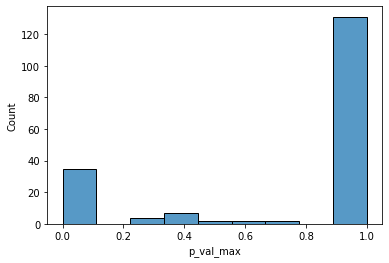

In [14]:
%matplotlib inline
sns.histplot(shuffle_out["p_val_max"])
plt.savefig(join(OUTDIR,"histogram_p_values_max.png"))

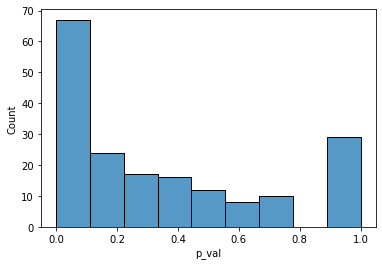

In [15]:
%matplotlib inline
sns.histplot(shuffle_out["p_val"])
plt.savefig(join(OUTDIR,"histogram_p_values_all.png"))

In [16]:
# enrich_df,all_enrich_l,all_enrich_max_l = shuffle_clones(enrich_f, cells_meta_f, outdir=OUTDIR, names=samples)

# all_enrich_l = np.array(all_enrich_l)
# all_enrich_max_l = np.array(all_enrich_max_l)

# sig_val = np.percentile(all_enrich_l, perc_thresh)
# shuffle_p = enrich_df['Fisher -log10p'].apply(lambda x: sum(x>all_enrich_l)/len(all_enrich_l))
# enrich_df['shuffle_sig'] = enrich_df['Fisher -log10p'] > sig_val
# enrich_df['p_val'] = 1-shuffle_p


# sig_val_max = np.percentile(all_enrich_max_l, perc_thresh)
# shuffle_p_max = enrich_df['Fisher -log10p'].apply(lambda x: sum(x>all_enrich_max_l)/len(all_enrich_max_l))
# enrich_df['shuffle_sig_max'] = enrich_df['Fisher -log10p'] > sig_val_max
# enrich_df['p_val_max'] = 1-shuffle_p_max
# enrich_df

# enrich_df[["lineage", "p_val", "shuffle_sig", "p_val_max", "shuffle_sig_max"]].sort_values("p_val")

In [17]:
# print('comparisons', comparisons)
# if comparisons is not None and comparisons != "None":
#     comps = comparisons.split(";")
#     print('comps', comps)
#     comps_out = []
#     comps_out_csv = []
#     for c in comps:
#         name, a, b = c.split(',')
#         print('name, a,b', name, a, b)
#         samples = [a, b]
#         enrich_d = dirname(enrich_f)
#         curr_enrich_df = shuffle_clones(join(enrich_d,f"{name}_enrichmentNorm.csv"), cells_meta_f, outdir=OUTDIR,
#                                    names=[a, b], name=f"{name}_")
#         comps_out.append(join(OUTDIR, f"{name}_donor{donor}.clone_shuffle.pdf"))
#         comps_out_csv.append(curr_enrich_df)
#     cmd = f"convert -append {' '.join(comps_out)} {join(OUTDIR, f'donor{donor}.clone_shuffle.pdf')}"
#     print('cmd', cmd)
#     os.system(cmd)
#     df = pd.concat(comps_out_csv, axis=0)
#     print('df', df.head())
#     df.to_csv(join(OUTDIR, f"donor{donor}.clone_shuffle.csv"))
# else:
#     samples = samples.split(',')
#     shuffle_clones(enrich_f, cells_meta_f, outdir=OUTDIR, names=samples)